#### Import Libraries

In [2]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from PIL import Image
import random
from sklearn.cross_validation import train_test_split
#from tqdm import tnrange

#### Define functions

In [3]:
resize_default=64

def resizeImg(image):
    img_w=image.size[0]
    img_h=image.size[1]

    slot = int(img_w/100) +1 if img_w > img_h else int(img_h/100) +1 
    
    if slot!=0:
        if img_w >= img_h:
            img = image.resize((resize_default,int(resize_default*img_h/img_w)), Image.ANTIALIAS)
        else:
            img = image.resize((int(resize_default*img_w/img_h),resize_default), Image.ANTIALIAS)
        
    return img;

def padImg(image):
    img_w=image.size[0]
    img_h=image.size[1]
    
    if img_w > resize_default or img_h > resize_default:
        if img_w >= img_h:
            new_size = (img_w, img_w)
        else:
            new_size = (img_h, img_h)
    else:
        new_size = (resize_default, resize_default)
        
    img = Image.new("RGB", new_size)
    img.paste(image, (int((new_size[0]-img_w)/2),int((new_size[1]-img_h)/2)))
        
    return img;

# extract labels
# positives = [1, 0], negatives = [0, 1]
def get_label(path):
    if path.split('/')[-1:][0].startswith('cat'): 
        return np.array([1, 0])
    else:
        return np.array([0, 1])

def getXYBatch(X_input, Y_input, batch_size):   
    X_array = np.array(padImg(resizeImg(Image.open(X_input[0])))).reshape([-1]) / 255
    Y_array = Y_input[0]

    choice = np.random.choice(range(len(X_input)), batch_size, replace=False)
    for item in choice:
        tmpimg = np.array(padImg(resizeImg(Image.open(X_input[item])))).reshape([-1]) / 255
        X_array = np.vstack((X_array, tmpimg))
        Y_array = np.vstack((Y_array,Y_input[item]))

    X_array = X_array[1:]
    Y_array = Y_array[1:]
    
    X_array = X_array.reshape([-1,resize_default,resize_default,3])
    
    return X_array, Y_array;

#### Read data and split training and testing groups

In [4]:
train_path = "data/train"
images = glob.glob(os.path.join(train_path, "*.jpg"))
random.shuffle(images)

# extract pixels
data_images = images
        
data_labels = np.array([get_label(p) for p in images])
data_labels_out = np.argmax(data_labels, 1)

print("Positive samples: %i\nNegative samples: %i \n" % (len(data_labels_out)-np.count_nonzero(data_labels_out)
                                                      , np.count_nonzero(data_labels_out)))
#Split Data Sets
X_train, X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.2)
y_train_out = np.argmax(y_train, 1)
y_test_out = np.argmax(y_test, 1)

print("Train:")
print("Positive samples: %i\nNegative samples: %i" % (len(y_train_out)-np.count_nonzero(y_train_out)
                                                      , np.count_nonzero(y_train_out)))  
print("Positive ratio: %.4f" % ((len(y_train_out)-np.count_nonzero(y_train_out) ) / len(y_train_out)) )
print("-------------------------")
print("Test:")
print("Positive samples: %i\nNegative samples: %i" % (len(y_test_out)-np.count_nonzero(y_test_out)
                                                      , np.count_nonzero(y_test_out)))
print("Positive ratio: %.4f" % ((len(y_test_out)-np.count_nonzero(y_test_out) ) / len(y_test_out)) )


Positive samples: 12500
Negative samples: 12500 

Train:
Positive samples: 9981
Negative samples: 10019
Positive ratio: 0.4990
-------------------------
Test:
Positive samples: 2519
Negative samples: 2481
Positive ratio: 0.5038


#### Convolution and Maxpool function definitions

In [5]:
def dropout(x, prob, train_phase):
    return tf.cond(train_phase, 
                   lambda: tf.nn.dropout(x, prob),
                   lambda: x)

def weight_variable(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
  return tf.Variable(tf.constant(0.1, shape=shape))

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

#### Network

In [6]:
sess = tf.InteractiveSession()

# tf Graph Input
x = tf.placeholder(tf.float32, [None,64,64,3]) 
y = tf.placeholder(tf.float32, [None, 2])

# dropout placeholder
keep_prob = tf.placeholder(tf.float32)

# train flag placeholder
train_phase = tf.placeholder(tf.bool) # For Batch Normalization

# Set model weights
W1 = weight_variable([3, 3, 3, 32])
b1 = bias_variable([32])

W2 = weight_variable([3, 3, 32, 64])
b2 = bias_variable([64])

W3 = weight_variable([3, 3, 64, 64])
b3 = bias_variable([64])

W4 = weight_variable([16 * 16 * 64, 512])
b4 = bias_variable([512])

W5 = weight_variable([512, 2])
b5 = bias_variable([2])

# hidden layers
conv1 = tf.nn.relu(conv2d(x, W1) + b1)
maxp1 = max_pool_2x2(conv1)

conv2 = tf.nn.relu(conv2d(maxp1, W2) + b2)
#maxp2 = max_pool_2x2(conv2)

conv3 = tf.nn.relu(conv2d(conv2, W3) + b3)
maxp3 = max_pool_2x2(conv3)

# fully connected
maxp3_flat = tf.reshape(maxp3, [-1, 16 * 16 * 64])

full1 = tf.nn.relu(tf.matmul(maxp3_flat, W4) + b4)
drop1 = tf.nn.dropout(full1, keep_prob)

#output
output = tf.matmul(drop1, W5) + b5
softmax=tf.nn.softmax(output)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y))

all_variables = tf.trainable_variables() 

#### Optimization and Training configuration

In [7]:
starter_learning_rate = 0.0005
decay_steps = 100
decay_rate  = 0.9 # the learning rate will decrement by this rate
regularization_strength = 0.001

L2_regularization = tf.add_n([tf.nn.l2_loss(v) for v in all_variables if 'BatchNorm' not in v.name])  # fix for BN
loss = loss + L2_regularization * regularization_strength

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           decay_steps, decay_rate, staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

# Getting predictions and accuracy
predictions = tf.argmax(softmax, 1)
correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

print("Model constructed, initializing all variables...")

# initialize variables
sess.run(tf.initialize_all_variables())

print("Finished")

Model constructed, initializing all variables...
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Finished


#### Training 

Step 00001: accuracy=0.5000	loss=34.177753	learning rate=0.000500
Step 00100: accuracy=0.6140	loss=23.074671	learning rate=0.000450
Step 00200: accuracy=0.7060	loss=17.580769	learning rate=0.000405
Step 00300: accuracy=0.7180	loss=14.476569	learning rate=0.000364
Step 00400: accuracy=0.7640	loss=12.555551	learning rate=0.000328
Step 00500: accuracy=0.7620	loss=11.225095	learning rate=0.000295
Step 00600: accuracy=0.7900	loss=10.200352	learning rate=0.000266
Step 00700: accuracy=0.8300	loss=9.427782	learning rate=0.000239
Step 00800: accuracy=0.8040	loss=8.817141	learning rate=0.000215
Step 00900: accuracy=0.8200	loss=8.298396	learning rate=0.000194
Step 01000: accuracy=0.8440	loss=7.822309	learning rate=0.000174
Step 01100: accuracy=0.8740	loss=7.423295	learning rate=0.000157
Step 01200: accuracy=0.8660	loss=7.102077	learning rate=0.000141
Step 01300: accuracy=0.8940	loss=6.781087	learning rate=0.000127
Step 01400: accuracy=0.8980	loss=6.550253	learning rate=0.000114
Step 01500: accura

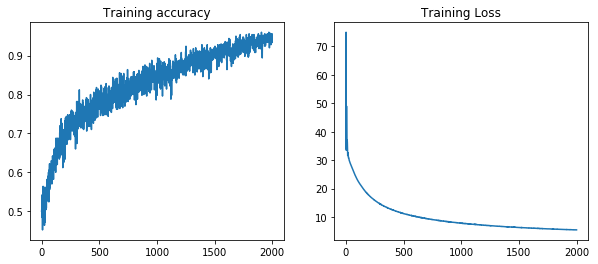

In [8]:
# Hyper-parameters
training_steps = 2000
batch_size = 500
display_step = 100

# Mini-batch Gradient Descent
training_accuracy = []
training_loss     = []

for i in range(training_steps):
    
    X,Y = getXYBatch(X_train,y_train,batch_size)
    
    batch_accuracy, batch_loss, _ = sess.run([accuracy, loss, train_step],
                                             feed_dict={x:X, y:Y, train_phase: True, keep_prob: 1.0})
    training_accuracy.append(batch_accuracy)
    training_loss.append(batch_loss)
    # Displaying info
    if (i+1)%display_step == 0 or i == 0:
        print("Step %05d: accuracy=%.4f\tloss=%.6f\tlearning rate=%.6f" %
              (i+1, batch_accuracy, batch_loss, learning_rate.eval()))

save_path = saver.save(sess, "./saved/model2K .ckpt")
print("Model saved in file: %s" % save_path)      
        
plt.figure(figsize=(10,4))
plot_titles = ["Training accuracy", "Training Loss"]
for i, plot_data in enumerate([training_accuracy, training_loss]):
    plt.subplot(1, 2, i+1)
    plt.plot(plot_data)
    plt.title(plot_titles[i])

#### Live usage

Predicted: Cat


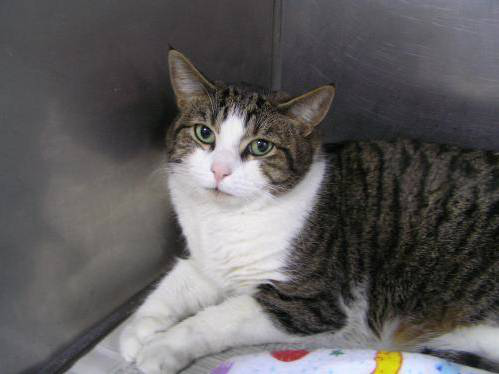

In [46]:
y=tf.nn.softmax(output)
test_img = Image.open(X_test[int(np.random.uniform(0, len(X_test)))])

input_array = np.array(padImg(resizeImg(test_img))).reshape([-1]) / 255
input_array = input_array.reshape([-1,64,64,3])

softmax=tf.nn.softmax(output)
prediction = sess.run(tf.argmax(y, 1), feed_dict={x: input_array, train_phase: False, keep_prob: 1.0})
print("Predicted: " + ("Cat" if prediction[0]==0 else "Dog"))
test_img